# Simple Fall Detection with Pose Estimate

Import Packages

In [16]:
from ultralytics import YOLO
import cv2
import time
from matplotlib import pyplot as plt
import numpy as np
import math

Load Model

In [3]:
# load Yolo pre-trained pose model
model = YOLO("yolo-weights/yolov8n-pose.pt")

Load Image

In [4]:
# example image location
img_src = "./test-data/images/sit-1.jpg"
# read with opencv
frame = cv2.imread(img_src)
# resize to 640x640
frame = cv2.resize(frame, (640,640))

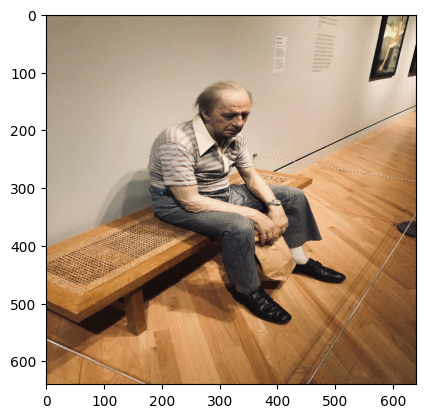

In [5]:
# display sample image
plt.imshow(frame[:,:,::-1])

Predict with model

In [6]:
results = model.track(frame, conf=0.5)


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 640)


Extract keypoints

In [12]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

IMPORTANT_PTS = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip', 'left_knee', 'right_knee']

conf_threshold = 0.4


In [14]:
# Yolo helper functions
def get_xy(keypoint):
    """ Convert Yolo tensor keypoint data to array and returns (x,y)  """
    try:
        return int(keypoint[0].item()), int(keypoint[1].item())
    except:
        raise Exception("unable to get keypoint coordinate")

def get_conf(conf_scores, part):
    """ Return confidence score for each keypoint (float). Input conf_scores is keypoint.conf (list). """
    try:
        return float(conf_scores[KEYPOINT_DICT[part]])
    except:
        raise Exception("unable to get confidence score")

# Helper Functions
def calculate_midpoint(point1, point2):
    """ Calculate midpoint between two 2D points. Returns midpoint (x,y) """
    x1, y1 = point1
    x2, y2 = point2
    midpoint_x = int((x1 + x2) / 2)
    midpoint_y = int((y1 + y2) / 2)
    return (midpoint_x, midpoint_y)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle (deg) between vectors v1 and v2 """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return math.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def draw_keypoint(image, keypoint):
    """ Takes image and keypoint to use OpenCV to draw pose keypoints on image and returns annotated image. """
    cv2.circle(image, (keypoint[0], keypoint[1]), 5, (0, 255, 0), -1)

def draw_keypoint_line(image, keypoint1, keypoint2):
    """ Draws line between two keypoints onto image and returns annotated image. """
    cv2.line(image, keypoint1, keypoint2, (255, 255, 255), 4)

def draw_vector(image, start_point, vector, color=(255, 255, 255), thickness=4):
    """ Draws vector to image with OpenCV line. Takes in starting point, vector, and image to draw on.   """
    end_point = tuple(np.array(start_point) + np.array(vector))
    cv2.line(image, tuple(start_point), end_point, color, thickness)

def get_mainpoint(left, right, left_conf_score, right_conf_score, conf_threshold=0.5, part="part"):
    """ 
    For each important part (eg. hip), if both left and right part exists and 
    confidence score is past threshold, we get midpoint. 
    
    If only left or right exist, then we set the point to left or right. 
    
    Returns midpoint (x,y) coordinate
    """
    main_point = (0,0)
    if left != (0,0) and right != (0,0) and left_conf_score>conf_threshold and right_conf_score>conf_threshold:
        print(f'both left and right {part} detected')
        main_point = calculate_midpoint(left, right)
    elif left != (0,0) and left_conf_score>conf_threshold:
        print(f'only left {part} detected')
        main_point = left
    elif right != (0,0) and right_conf_score>conf_threshold:
        print(f'only right {part} detected')
        main_point = right
    return main_point


def calculate_vector(point1, point2):
    """ Returns 2D vector between two points (x,y). """
    x1, y1 = point1
    x2, y2 = point2
    vector_x = x2 - x1
    vector_y = y2 - y1
    return (vector_x, vector_y)


In [18]:
# go through all results
for result in results:
    # extract keypoints from result
    keypts = result.keypoints
    # print(f'Keypoints: \n{kpts}')
    # extract number of people and number of keypoints
    num_people = keypts.shape[0]
    num_pts = keypts.shape[1]
    
    
    if num_pts !=0:
        # for each person
        for i in range(num_people):
            # extract relevant keypoints and confidence scores into nested dict
            keypts_dict = {}
            for parts in IMPORTANT_PTS:
                keypts_dict[parts] = {}
                keypts_dict[parts]['xy'] = get_xy(keypts.xy[i, KEYPOINT_DICT[parts]])
                keypts_dict[parts]['conf_score'] = get_conf(keypts.conf[i], parts)
            
            # check whether left/right keypt exist, if both exist get midpoint
            shoulder = get_mainpoint(keypts_dict['left_shoulder']['xy'], keypts_dict['right_shoulder']['xy'], 
                                            keypts_dict['left_shoulder']['conf_score'], keypts_dict['right_shoulder']['conf_score'], conf_threshold=conf_threshold,  part = "shoulders")
            hips = get_mainpoint(keypts_dict['left_hip']['xy'], keypts_dict['right_hip']['xy'], keypts_dict['left_hip']['conf_score'], 
                                        keypts_dict['right_hip']['conf_score'], conf_threshold=conf_threshold, part = "hips")
            knees = get_mainpoint(keypts_dict['left_knee']['xy'], keypts_dict['right_knee']['xy'], keypts_dict['left_knee']['conf_score'], 
                                        keypts_dict['right_knee']['conf_score'], conf_threshold=conf_threshold, part = "knees")
            
            # track if main parts exist
            shoulder_exist = False
            hips_exist = False
            knees_exist = False
            
            # if relevant keypt exist draw pt
            if shoulder!=(0,0):
                shoulder_exist = True
                draw_keypoint(frame, shoulder)
                # print(f'Shoulder: {shoulder}')
            if hips!=(0,0):
                hips_exist = True
                draw_keypoint(frame, hips)
                # print(f'Hips: {hips}')
            if knees!=(0,0):
                knees_exist = True
                draw_keypoint(frame, knees)
                # print(f'Knees: {knees}')
                
            # if keypts exist draw line to connect them, calculate vector and distances
            spine_vector = (0,0)
            legs_vector = (0,0)
            if shoulder_exist and hips_exist:
                spine_vector = calculate_vector(hips, shoulder)
                # draw_keypoint_line(frame, shoulder, hips)
                draw_vector(frame, hips, spine_vector)
                # print(f'Spine Vector: {spine_vector}')
            if hips_exist and knees_exist:
                legs_vector = calculate_vector(hips, knees)
                # draw_keypoint_line(frame, hips, knees)
                draw_vector(frame, hips, legs_vector)
                # print(f'Leg Vector: {legs_vector}')
            
            
            # calculate vector if all 3 main pts exist
            spine_leg_theta = -1 # angle between spine (vector between shoulder and hips) and legs (vector between hips and knees)
            spine_x_axis_phi = -1 # angle between spine (vector between shoulder and hips) and x_axis along hip point
            legs_y_axis_alpha = -1 # angle between legs (vector between hips and knees) and y_axis along hip point
            if shoulder_exist and hips_exist and knees_exist:
                spine_leg_theta = angle_between(spine_vector, legs_vector)
                hips_x_axis = calculate_vector(hips, (hips[0]+20, hips[1]))
                hips_y_axis = calculate_vector(hips, (hips[0], hips[1]+20))
                # draw_vector(frame, hips, hips_x_axis, color=(255,255,255))
                # spine_x_axis_phi = calculate_angle_with_x_axis(spine_vector)
                spine_x_axis_phi = angle_between(spine_vector, hips_x_axis)
                legs_y_axis_alpha = angle_between(legs_vector, hips_y_axis)
                print(f'Person {i+1}')
                print(f'Theta {spine_leg_theta}, Phi: {spine_x_axis_phi}, Alpha: {legs_y_axis_alpha}')

both left and right shoulders detected
both left and right hips detected
both left and right knees detected
Person 1
Theta 88.90680968883534, Phi: 82.68098062440957, Alpha: 83.77417093557423


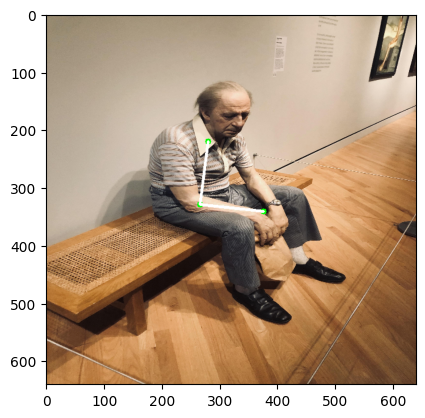

In [19]:
# display annotated image
plt.imshow(frame[:,:,::-1])